In [1]:
# load all libraries reqd for the project
#Steps for the project
#1.Camera calibration - done
#2.Distortion correction - done
#3.Color/gradient threshold - done
#4.Perspective transform - done
#5.Detect lane lines
#6.Determine the lane curvature
import numpy as np
import cv2
import scipy.ndimage as snd
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
nx, ny = 9, 6
objp = np.zeros((nx*ny,3),np.float32) # 3d real world space
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
objpts = [] # 3d real world space
imgpts = [] # 2d corners
inames = glob.glob('camera_cal/calibration*.jpg')
#plt.imshow(snd.imread(inames[0]))
for iimage in range(len(inames)):
    #plt.imshow(snd.imread(inames[5]))
    img = snd.imread(inames[iimage])
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #plt.imshow(gray)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    #print(ret)
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)
        #iimg = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #plt.imshow(iimg)

In [3]:
# return camera matrix (mtx), distortion coefficients (dist)
retc, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts,imgpts,img.shape[0:2],None,None)
"""img = snd.imread(inames[5])
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(img)
undistort = cv2.undistort(img,mtx,dist,None,mtx)
ax2.imshow(undistort)
"""

'img = snd.imread(inames[5])\nf, (ax1, ax2) = plt.subplots(1,2)\nax1.imshow(img)\nundistort = cv2.undistort(img,mtx,dist,None,mtx)\nax2.imshow(undistort)\n'

In [4]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= np.min(mag_thresh)) & (scaled_sobel <= np.max(mag_thresh))] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return mag_binary
    
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(dir_gradient)
    dir_binary[(dir_gradient >= np.min(thresh)) & (dir_gradient <= np.max(thresh))] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return dir_binary

def color_threshold(img,thresh = (0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= np.min(thresh)) & (s_channel <= np.max(thresh))] = 1
    return s_binary

(720, 1280, 3)

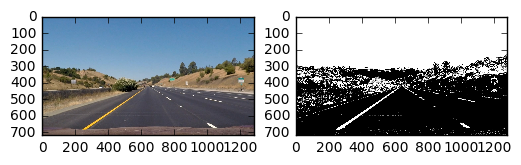

In [227]:
onames = glob.glob('test_images/*.jpg')
image = snd.imread(onames[0])
f, (ax3,ax4) = plt.subplots(1,2)
ax3.imshow(image)
gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
s_binary   = color_threshold(image,thresh=(90,255))
combined = np.zeros_like(dir_binary)
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
# color_binary = np.dstack(( np.zeros_like(s_binary), s_binary)
combined[((gradx == 1) ) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
ax4.imshow(combined,'gray')
image.shape

In [228]:
def lane_lines_source_pts(edges_image):
    # inspiration from project P1
    # mask the image
    mask = np.zeros_like(edges_image)   
    ignore_mask_color = 255
    imshape = edges_image.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2.6, imshape[0]/1.6),\
                                                (imshape[1]/1.3, imshape[0]/1.6),(imshape[1],imshape[0])]], dtype=np.int32)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    edges_roi = cv2.bitwise_and(edges_image*255, mask)
    
    # generate hough lines
    threshold, min_line_len, max_line_gap = 15, 20, 5
    lines = cv2.HoughLinesP(np.uint8(edges_roi), 1, np.pi/180, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*edges_image.shape, 3), dtype=np.uint8)
    
    # Find lines of interest and combine them to get edges of line
    rFit = []
    lFit = []
    lLength = []
    rLength = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slopeLine = ((y2-y1)/(x2-x1))
            if slopeLine > 0.5: # right lane
                rFit.append(np.polyfit((x1,x2), (y1,y2),1))
                rLength.append(np.sqrt(np.square(x2-x1)+np.square(y2-y1)))
            elif slopeLine < -0.5: # left lane 
                lFit.append(np.polyfit((x1,x2),(y1,y2),1))
                lLength.append(np.sqrt(np.square(x2-x1)+np.square(y2-y1)))
    lFit = np.asarray(lFit)
    rFit = np.asarray(rFit)
    lLength = np.asarray(lLength)
    rLength = np.asarray(rLength)
    lSort = np.zeros((lLength.size,3))
    rSort = np.zeros((rLength.size,3))
    
    # sort according to line length
    """ # THIRD TRY - if one of the lines not available then don't draw anything"""
    if (lFit.shape[0] != 0 and rFit.shape[0] != 0):
        lSort[:,1:] = lFit
        lSort[:,0] = lLength
        lSort = np.array(lSort)
        lSort = lSort[np.argsort(lSort[:,0])]
        rSort[:,1:] = rFit
        rSort[:,0] = rLength
        rSort = np.array(rSort)
        rSort = rSort[np.argsort(rSort[:,0])]

        # average with weighting according to line length, bigger line length - more the weight
        lAvg = [np.average(lSort[:,1],weights=np.arange(1,(lSort.shape)[0]+1,1)), \
                np.average(lSort[:,2],weights=np.arange(1,(lSort.shape)[0]+1,1))]
        rAvg = [np.average(rSort[:,1],weights=np.arange(1,(rSort.shape)[0]+1,1)), \
                np.average(rSort[:,2],weights=np.arange(1,(rSort.shape)[0]+1,1))]

        # 320 to 540 is the y axis or vertical axis minimum and maximum horizon for line extrapolation
        ymax   = imshape[0]
        ymin   = np.int(np.round(ymax/1.6))
        x2lAvg = np.int((ymin-lAvg[1])/lAvg[0])
        x1lAvg = np.int((ymax-lAvg[1])/lAvg[0])
        x2rAvg = np.int((ymin-rAvg[1])/rAvg[0])
        x1rAvg = np.int((ymax-rAvg[1])/rAvg[0])
        
        corners = np.float32([[x1lAvg, ymax],
                              [x2lAvg, ymin],
                              [x2rAvg, ymin],
                              [x1rAvg, ymax]])
        
    return corners

In [229]:
def corners_unwarp(img, mtx, dist):
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    #gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    gradx = abs_sobel_thresh(undist, orient='x', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(undist, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3))
    s_binary   = color_threshold(undist,thresh=(90,255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) ) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    #gray = combined
    # 3) Find the corners
    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
    src = lane_lines_source_pts(combined)
    #offset = 100 # offset for dst points
    img_size = (combined.shape[1], combined.shape[0])
    #src = np.float32([[offset*2, img_size[1]],
    #                  [img_size[0]/2-offset*0.6, img_size[1]/2+offset],
    #                  [img_size[0]/2+offset*0.8, img_size[1]/2+offset],
    #                  [img_size[0]-offset*1.5, img_size[1]]])
        #Note: you could pick any four of the detected corners 
        # as long as those four corners define a rectangle
        #One especially smart way to do this would be to use four well-chosen
        #corners that were automatically detected during the undistortion steps
        #We recommend using the automatic detection of corners in your code
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[src[0,0], img_size[1]], 
                     [src[0,0], 0], 
                     [src[3,0], 0],
                     [src[3,0], img_size[1]]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    #delete the next two lines
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv, undist, combined, src, dst

[[  208.   720.]
 [  594.   450.]
 [  676.   450.]
 [ 1107.   720.]]


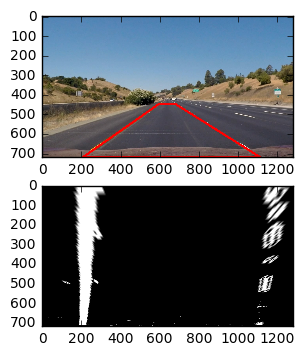

In [230]:
top_down, perspective_M, Minv, undist, binary_combined, src, dst = corners_unwarp(image, mtx, dist)
f, (ax5,ax6) = plt.subplots(2,1)
f.clear
#ax5.imshow(image)
#ax5.imshow(cv2.line(image,tuple(dst[0,:]),tuple(dst[1,:]),(0,255,255),5))
points = np.array(src,dtype = np.int32)
ax5.imshow(cv2.polylines(image,[points],1,(255,0,0),thickness = 10))
ax6.imshow(top_down,cmap = 'gray')
print(src)

In [231]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output
def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

In [232]:
# Find lanes lines from binary_warped image
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
window_centroids = find_window_centroids(top_down, window_width, window_height, margin)
print(window_centroids)
y_centroids = np.arange(window_height/2,top_down.shape[0],window_height)

[(214.0, 1111.0), (215.0, 1114.0), (219.0, 1127.0), (221.0, 1148.0), (219.0, 1151.0), (221.0, 1152.0), (223.0, 1190.0), (224.0, 1184.0), (220.0, 1169.0)]


In [233]:
# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(top_down)
    r_points = np.zeros_like(top_down)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,top_down,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,top_down,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((top_down,top_down,top_down)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    # If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((top_down,top_down,top_down)),np.uint8)

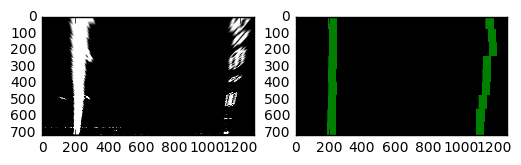

In [234]:
# Display the final results
f, (ax7,ax8) = plt.subplots(1,2)
ax7.imshow(top_down,cmap = 'gray')
ax8.imshow(output)

(720, 0)

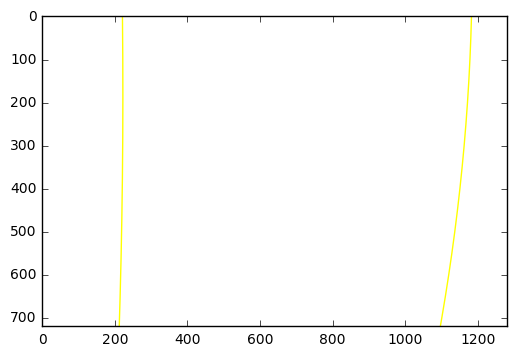

In [235]:
# draw the lines
window_centroids_array = np.asarray(window_centroids)
leftx    = np.flipud(window_centroids_array[:,0])
rightx   = np.flipud(window_centroids_array[:,1])

left_fit = np.polyfit(y_centroids,leftx,2)
right_fit = np.polyfit(y_centroids,rightx,2)
#generate a line
ploty = np.linspace(0, binary_combined.shape[0]-1, binary_combined.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [236]:
#get radius of curvature
y_eval = np.max(ploty) # max value of y corresponding to bottom of image
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/900 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(y_centroids*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(y_centroids*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

14453.3351484 4315.57233969
6091.09198228 m 1711.55626149 m


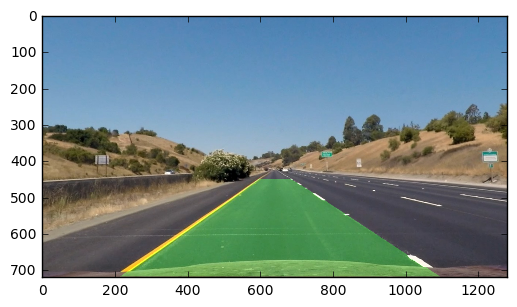

In [237]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(top_down).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)